In [41]:
import numpy as np
import matplotlib.pyplot as plt
import dunestyle.matplotlib as dunestyle
from scipy.interpolate import interp1d

In [3]:
FluxRotValues = np.array([[+0.9877, -0.1564, +0.0000],  # new x axis in old coordinates: be nice and fix things (ends up the same)
                        [+0.0000, +0.0000, +1.0000],  # new y axis in old coordinates: vertical
                        [-0.1564, -0.9877, +0.0000]])   # new z axis in old coordinates: away from Batavia, IL

Inverse_FluxRotValues = np.linalg.inv(FluxRotValues)

In [63]:
# Read the file
bartol_theta = np.loadtxt('TotalFlux_EvtDistr_theta_bartol_solmax_NuFIT4p1_NO_hA_BR.txt')

# Split into two arrays
cosrange = bartol_theta[:, 0][1:-1]
dndtheta = bartol_theta[:, 1][1:-1]

In [65]:
def log_interp1d(x, y, kind='linear'):
    """
    Logarithmic interpolation for y while keeping x linear.
    """
    y = np.clip(y, 1e-10, None)  # Avoid issues with zeros or negatives in y
    logy = np.log10(y)
    lin_interp = interp1d(x, logy, kind=kind, bounds_error=False, fill_value="extrapolate")
    return lambda z: np.power(10.0, lin_interp(z))

In [128]:
theta_inter = log_interp1d(cosrange,dndtheta)
cos_linear = np.linspace(-1,1,100001)

In [129]:
dndtheta_interp = [theta_inter(cos) for cos in cos_linear]

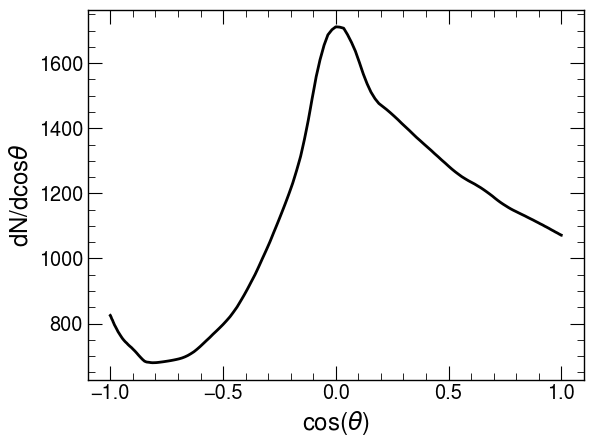

In [134]:
plt.figure(dpi=100)
plt.step(cos_linear,dndtheta_interp)
plt.ylabel(r'dN/dcos$\theta$')
plt.xlabel(r'cos($\theta$)')
plt.show()

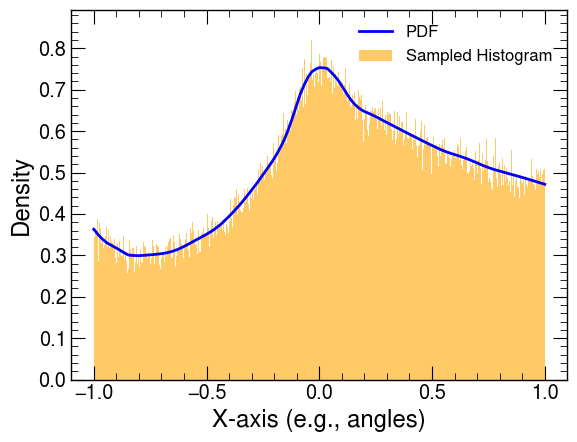

In [133]:

# Normalize y to create a PDF
pdf = dndtheta_interp / np.trapz(dndtheta_interp, cos_linear)  # Normalize using integration (area under the curve)

# Compute the CDF
cdf = np.cumsum(pdf * np.diff(np.append(cos_linear, cos_linear[-1] + (cos_linear[-1] - cos_linear[-2]))))  # Scale by dx for CDF
cdf /= cdf[-1]  # Normalize CDF to end at 1

# Function to sample from the PDF
def sample_from_pdf(x, cdf, size=1000):
    random_values = np.random.uniform(0, 1, size)
    sampled_indices = np.searchsorted(cdf, random_values)
    return x[sampled_indices]

# Sample random values
sampled_values = sample_from_pdf(cos_linear, cdf, size=4000000)
# Plot the original PDF
plt.plot(cos_linear, pdf, label="PDF", color="blue")

# Plot a histogram of sampled values
plt.hist(sampled_values, bins=10000, density=True, alpha=0.6, color="orange", label="Sampled Histogram")

# Labels and legend
plt.xlabel("X-axis (e.g., angles)")
plt.ylabel("Density")
plt.legend()
plt.show()

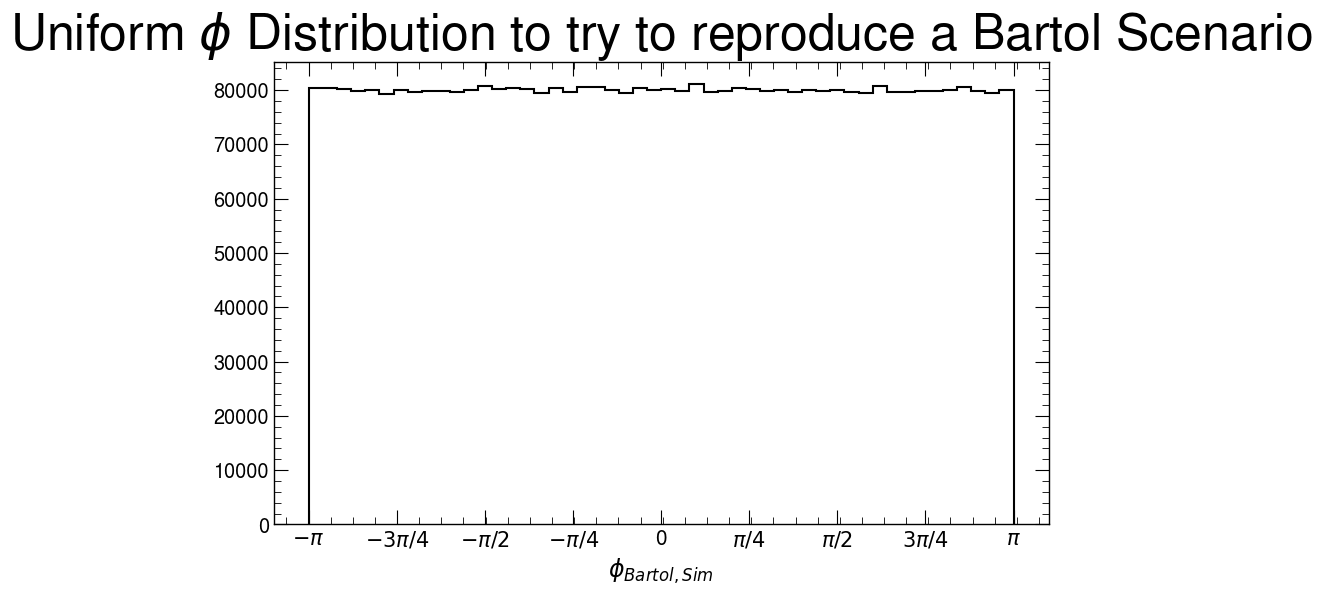

In [139]:
PhiBartolUnif = 2*np.pi*np.random.random_sample((sampled_values.size,))-np.pi
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
ax.hist(PhiBartolUnif, bins = 50,histtype = 'step')
plt.title(r'Uniform $\phi$ Distribution to try to reproduce a Bartol Scenario')
ax.set_xticks([-3.14559,-2.356,-1.570,-0.78539,0.0,0.78539,1.570,2.356,3.14159])
ax.set_xticklabels([r'$-\pi$',r'$ -3\pi / 4$', r'$-\pi / 2$', r'$-\pi / 4$',0,r'$\pi / 4$',r'$\pi / 2$', r'$3 \pi / 4$', r'$\pi$'], fontsize = 15)
ax.set_xlabel(r'$\phi_{Bartol, Sim}$', fontsize = 17)
plt.show()

In [138]:
import math
Sun_Positions = np.loadtxt('../../Optimization/background_sun_pos.dat', delimiter='\t', usecols=(0,1,2))
PlotSunDirection = []
SunPosInHondaCoorS = [Inverse_FluxRotValues.dot(SunPos)  for SunPos in Sun_Positions] 
Phi_Theta_NuMom_Unit = [PlotSunDirection.append((math.atan2(SunPos[1], SunPos[0]), math.acos(SunPos[2]))) for SunPos in SunPosInHondaCoorS] 

In [140]:
plot_dirdetc_nu_phiBartolIso = np.vstack((PhiBartolUnif, sampled_values)).T

In [141]:
def cosineAngle_wSphericalUnitVec(a,b):
    return np.sin(a[1])*np.sin(b[1])*np.cos(a[0]-b[0])+np.cos(a[1])*np.cos(b[1])

In [152]:
hist_cos_BartolCoordSys_PhiUnif = []
for index, atmevt in enumerate(plot_dirdetc_nu_phiBartolIso):
    indices = np.random.randint(0, len(PlotSunDirection), size=1)
    #print(indices[0])
    # Use the sampled indices to select elements from the array
    sample_sunpos = PlotSunDirection[indices[0]]
    #print(sample_sunpos[0])
    for sunpos in sample_sunpos:
        hist_cos_BartolCoordSys_PhiUnif.append(cosineAngle_wSphericalUnitVec(atmevt,sample_sunpos))


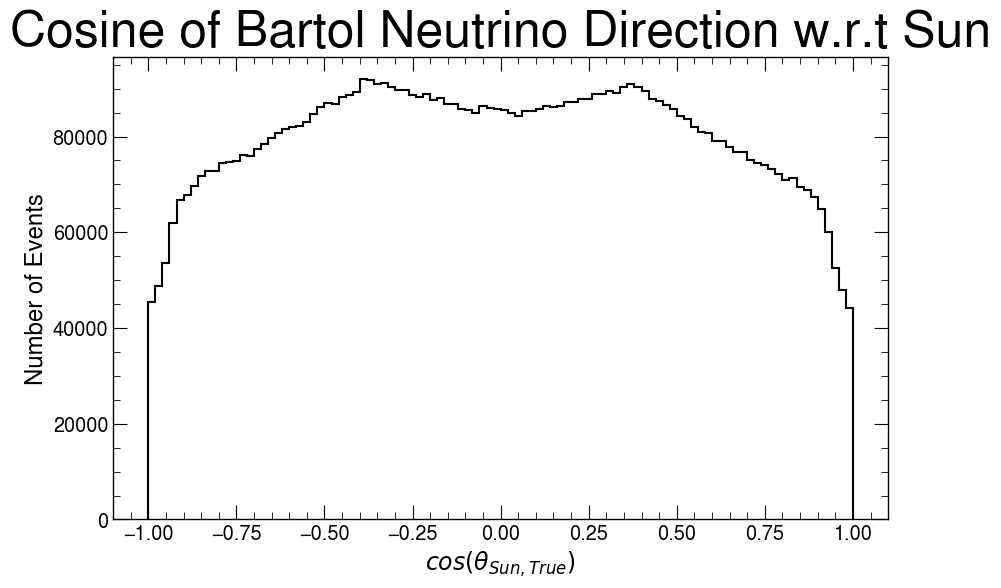

In [153]:
fig, ax = plt.subplots(dpi=100, figsize=(10, 6))
plt.hist(hist_cos_BartolCoordSys_PhiUnif, bins = 100,histtype = 'step')
plt.title(r'Cosine of Bartol Neutrino Direction w.r.t Sun')
plt.ylabel('Number of Events')
plt.xlabel(r'$cos(\theta_{Sun, True})$',fontsize = 17)
plt.show()